In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
test_ID = test.Id
y = train.SalePrice
qualitative = list(train.columns[train.dtypes == "object"])
quantitative = list(test.select_dtypes(include=['float64',"int64"]).columns)
quantitative.remove("Id")




In [16]:
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)
old_cols = [x for x in test.columns if x not in cols]

In [17]:
key = pd.DataFrame(columns=["index"], index=pd.MultiIndex.from_tuples([], names=['variable','value']))

for x in cols:
    kf = train.groupby(x)["SalePrice"].mean().to_frame().sort_values("SalePrice")
    kf = kf.reset_index().reset_index().drop(columns=["SalePrice"])
    kf["variable"] = x
    kf.index = kf.index + 1
    key = pd.concat([key, kf.rename(columns={x:"value"}).set_index(["variable","value"])])



In [18]:
train = train.drop("SalePrice", axis=1)
features = pd.concat([train, test])
reshape_df = pd.melt(features, id_vars="Id", value_vars=cols).merge(key, on=["variable","value"])
qualDf= reshape_df.pivot(index='Id', columns='variable')["index"]
#qualDf.columns = [str(x)+"_E" for x in qualDf.columns]
features = qualDf.merge(features[old_cols], on=["Id"])
#features = features.drop(features[features[cols].isnull().any(axis=1)].index)
features[cols] = features[cols].fillna(0)
features[cols] = features[cols].astype('int')
features = features.drop(columns=["Id"])

In [19]:
from scipy.stats import norm, skew
numeric_feats = features.dtypes[features.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = features[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    features[feat] = boxcox1p(features[feat], lam)


Skew in numerical features: 

There are 58 skewed numerical features to Box Cox transform


In [20]:
features[quantitative] = features[quantitative].fillna(0)
features = pd.get_dummies(features)

In [21]:
train = features[:len(y)]
test = features[len(y):]
y_train = np.log1p(y)

In [36]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder, StandardScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet,  LassoLarsIC, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.base import clone, BaseEstimator, TransformerMixin, RegressorMixin # Clone estimator
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import explained_variance_score, median_absolute_error, r2_score, mean_squared_error #To evaluate our model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor


In [45]:

seed = 5
n_folds =5
scoring='r2'
model = XGBRegressor()
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
cross_val_score(model, train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=1)    

array([0.89672344, 0.8959702 , 0.78699629, 0.88978656, 0.86744912,
       0.88409952, 0.90031969, 0.87378243, 0.8536853 , 0.85980302])

In [39]:



#creates a list of models
#create a pipeline by writing it out or using make_pipeline then you can test how well the model does using cross validation.
#however in order to use it you have to do model.fit()
##lasso/ridge alpha gives a standard for how many of the features should have linear coefficients of zero - higher alpha = higher standard
pipelines = []
seed = 5

#https://www.statisticshowto.com/ridge-regression/
#just enough biased variables so that it does not become too varianced 
#Ridge regression is a way to create a parsimonious model when the number of predictor variables in a set exceeds the number of observations, or when a data set has multicollinearity (correlations between predictor variables).
pipelines.append(
                ("Scaled_Ridge", 
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Ridge", Ridge(random_state=seed, alpha= 0.1, tol=0.1, solver='auto' ))]
                 )))
#https://www.statisticshowto.com/lasso-regression/ 
#Sparse using alpha decreases the amount of variables like ridge
#Lasso, or Least Absolute Shrinkage and Selection Operator, is quite similar conceptually to ridge regression. It also adds a penalty for non-zero coefficients, but unlike ridge regression which penalizes sum of squared coefficients (the so-called L2 penalty), lasso penalizes the sum of their absolute values (L1 penalty). As a result, for high values of λ, many coefficients are exactly zeroed under lasso, which is never the case in ridge regression.
pipelines.append(
                ("Scaled_Lasso", 
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Lasso", Lasso(random_state=seed, alpha=.0005, tol=0.1))]
                 )))
#Elastic Net first emerged as a result of critique on lasso, whose variable selection can be too dependent on data and thus unstable. The solution is to combine the penalties of ridge regression and lasso to get the best of both worlds.
pipelines.append(
                ("Scaled_Elastic", 
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Lasso", ElasticNet(random_state=seed, alpha=.0005, tol=0.1))]
                 )))

pipelines.append(
                ("Scaled_RF_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("RF", RandomForestRegressor(random_state=seed))]
                 )))

pipelines.append(
                ("Scaled_ET_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("ET", ExtraTreesRegressor(random_state=seed))]
                 )))

pipelines.append(
                ("Scaled_BR_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BaggingRegressor(random_state=seed))]
                 ))) 

pipelines.append(
                ("Scaled_Hub-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Hub-Reg", HuberRegressor())]
                 ))) 

pipelines.append(
                ("Scaled_BayRidge",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BayesianRidge())]
                 ))) 

pipelines.append(
                ("Scaled_XGB_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("XGBR", XGBRegressor(seed=seed, n_estimators=300))]
                 ))) 

pipelines.append(
                ("Scaled_DT_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("DT_reg", DecisionTreeRegressor())]
                 ))) 

"""pipelines.append(
                ("Scaled_SVR",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("SVR",  SVR(kernel='linear', C=1e3, degree=2))]
                 )))"""

pipelines.append(
                ("Scaled_KNN_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("KNN_reg", KNeighborsRegressor())]
                 )))
pipelines.append(
                ("Scaled_ADA-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("ADA-reg", AdaBoostRegressor())
                 ]))) 

pipelines.append(
                ("Scaled_Gboost-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("GBoost-Reg", GradientBoostingRegressor())]
                 )))

pipelines.append(
                ("Scaled_RFR_PCA",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("PCA", PCA(n_components=3)),
                     ("XGB", RandomForestRegressor())]
                 )))

pipelines.append(
                ("Scaled_XGBR_PCA",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("PCA", PCA(n_components=3)),
                     ("XGB", XGBRegressor())]
                 )))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'r2'
n_folds = 7

results, names  = [], [] 

for name, model  in pipelines:
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)
    


Scaled_Ridge: 0.864244 (+/- 0.047072)
Scaled_Lasso: 0.835288 (+/- 0.056140)
Scaled_Elastic: 0.829692 (+/- 0.054350)
Scaled_RF_reg: 0.867030 (+/- 0.012854)
Scaled_ET_reg: 0.872291 (+/- 0.013963)
Scaled_BR_reg: 0.855634 (+/- 0.017623)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs fa

Scaled_Hub-Reg: 0.869285 (+/- 0.046844)
Scaled_BayRidge: 0.876201 (+/- 0.045216)
Scaled_XGB_reg: 0.872813 (+/- 0.013412)
Scaled_DT_reg: 0.722634 (+/- 0.030250)
Scaled_KNN_reg: 0.736898 (+/- 0.035736)
Scaled_ADA-Reg: 0.806024 (+/- 0.027227)
Scaled_Gboost-Reg: 0.894294 (+/- 0.014397)
Scaled_RFR_PCA: 0.813636 (+/- 0.019329)
Scaled_XGBR_PCA: 0.798286 (+/- 0.020575)


[Text(0, 0, 'Scaled_Ridge'),
 Text(0, 0, 'Scaled_Lasso'),
 Text(0, 0, 'Scaled_Elastic'),
 Text(0, 0, 'Scaled_RF_reg'),
 Text(0, 0, 'Scaled_ET_reg'),
 Text(0, 0, 'Scaled_BR_reg'),
 Text(0, 0, 'Scaled_Hub-Reg'),
 Text(0, 0, 'Scaled_BayRidge'),
 Text(0, 0, 'Scaled_XGB_reg'),
 Text(0, 0, 'Scaled_DT_reg'),
 Text(0, 0, 'Scaled_KNN_reg'),
 Text(0, 0, 'Scaled_ADA-Reg'),
 Text(0, 0, 'Scaled_Gboost-Reg'),
 Text(0, 0, 'Scaled_RFR_PCA'),
 Text(0, 0, 'Scaled_XGBR_PCA')]

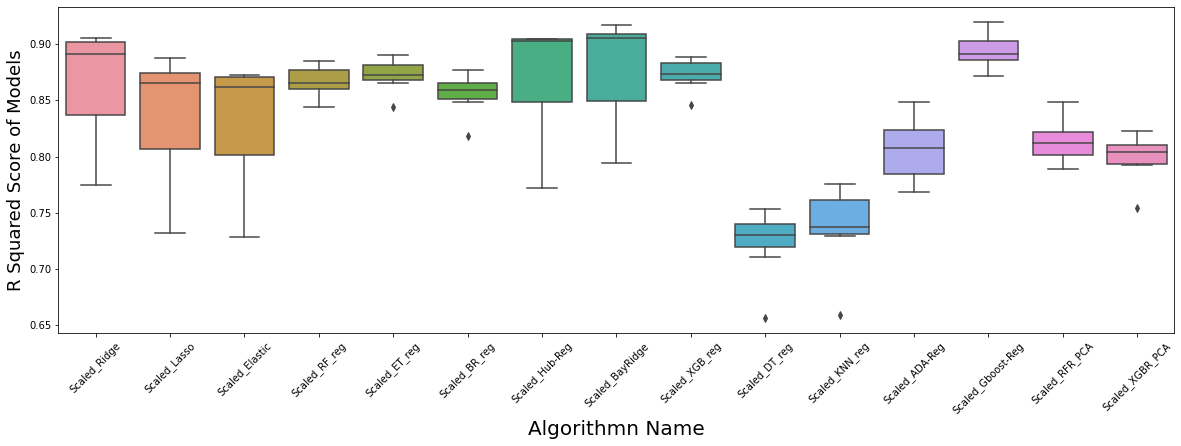

In [48]:
n = []
fig = plt.figure(figsize=(20, 6))
for x in range(len(names)): n += [[names[x],results[x][y]] for y in range(7)]
model_df = pd.DataFrame(n,columns=["name","result"])
ax = sns.boxplot(data=model_df, x="name", y='result')
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn Name", fontsize=20)
ax.set_ylabel("R Squared Score of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
#diamonds are outliers

In [42]:
model_df.tail(10)

,name,result
95,Scaled_RFR_PCA,0.830687
96,Scaled_RFR_PCA,0.812304
97,Scaled_RFR_PCA,0.848421
98,Scaled_XGBR_PCA,0.805436
99,Scaled_XGBR_PCA,0.803649
100,Scaled_XGBR_PCA,0.754003
101,Scaled_XGBR_PCA,0.792165
102,Scaled_XGBR_PCA,0.822813
103,Scaled_XGBR_PCA,0.795114
104,Scaled_XGBR_PCA,0.814820


In [50]:

predictions = (tpot.predict(test))
y_test = np.log1p(pd.read_csv("../input/full-score.csv")["SalePrice"])
rmse = np.sqrt(MSE(y_test, predictions)) 
print("RMSE : % f" %(rmse)) 


RMSE :  0.130294


In [51]:
predictions

array([11.69240266, 11.99078643, 12.12604181, ..., 11.982316  ,
       11.71499724, 12.34187075])

In [52]:
y_test

0       11.561725
1       12.055256
2       12.154258
3       12.183321
4       12.162648
          ...    
1454    11.413116
1455    11.170449
1456    11.782960
1457    11.790565
1458    12.144203
Name: SalePrice, Length: 1459, dtype: float64